# Implemenation: Grid Fitting using Bayesian Statistics w/ PICASO

If this is your first crack at fitting parameters with PICASO, we strongly encourage you to look at the first retrieval tutorial. Here, we will expand on that tutorial. 

**What you will learn:** 

1. How to load a grid and fit parameters using pre-computed spectra
2. How to analyze grid fitting results

**What you should know:**

1. `picaso`'s retrieval class structure (model_set, prior_set, param_set)
2. `picaso.retrieval.setup_retrieval` function to generate template scripts (covered in Retrieval Tutorial 1)

**What you will need:** 

We will build on the `line` fitting tutorial 1, using Grant et al. 2024 data. 

1. Download [WASP-17b grids here](www.doi.org/10.5281/zenodo.14681144) (unpacked it is 436 Mb)



Note, this is our most basic cloud-free grid. In the next tutorial, you'll learn how to add clouds and other features.

In [1]:
import numpy as np
import os 
import picaso.justdoit as jdi
import picaso.analyze as lyz
import xarray as xr
import matplotlib.pyplot as plt

## Step 1) Develop function to get data

(same as tutorial 1) 

Let's create a function to pull our data where all we need to do is declare who the data is from and it pulls it for us automatically.

Note: this format is only a recommendation and you can change any part of this to fit your needs 

In [2]:
def get_data(): 
    """
    Create a function to process your data in any way you see fit.
    Here we are using the ExoTiC-MIRI data 
    https://zenodo.org/records/8360121/files/ExoTiC-MIRI.zip?download=1
    But no need to download it.

    Checklist
    ---------
    - your function returns a spectrum that will be in the same units as your picaso model (e.g., rp/rs^2, erg/s/cm/cm or other) 
    - your function retuns a spectrum that is in ascending order of wavenumber 
    - your function returns a dictionary where the key specifies the instrument name (in the event there are multiple)

    Returns
    -------
    dict: 
        dictionary key: wavenumber (ascending), flux or transit depth, and error.
        e.g. {'MIRI LRS':[wavenumber, transit depth, transit depth error], 'NIRSpec G395H':[wavenumber, transit depth, transit depth error]}
    """
    dat = xr.load_dataset(jdi.w17_data())
    #build nice dataframe so we can easily view the data
    final = jdi.pd.DataFrame(dict(wlgrid_center=dat.coords['central_wavelength'].values,
                transit_depth=dat.data_vars['transit_depth'].values,
                transit_depth_error=dat.data_vars['transit_depth_error'].values))

    #create a wavenumber grid 
    final['wavenumber'] = 1e4/final['wlgrid_center']

    #always ensure we are ordered correctly
    final = final.sort_values(by='wavenumber').reset_index(drop=True)

    #return a nice dictionary with the info we need 
    returns = {'MIRI_LRS': [final['wavenumber'].values, 
             final['transit_depth'].values  ,final['transit_depth_error'].values]   }
    return returns

## Step 2) Load Grid 

Let's point towards the grid locations, create a grid fitter object for them, and prep them. 

If you are not familiar with `lyz.GridFitter` we encourate you to first become familiar with non-Bayesian grid fitting based on purely maximum chi-sq values. You can play around with this [Grid Search tutorial here](https://natashabatalha.github.io/picaso/notebooks/fitdata/GridSearch.html). 

The basic premise of `prep_gridtrieval`:
- vets and transforms the grid to ensure it's square and interpolate-able
- checks that there is a common pressure grid for the temperature

A few clarifications:

Square is a bit of a misnomer. We just mean the grid needs to be a solid A x B x C x … x N -type matrix (a 4x2x8 rectangle would be equally acceptable as a 5x5x5 square). You can’t have gaps or extra weird regions hanging on (e.g. a staircase would be bad). `prep_gridtrieval` will check that your grid is an acceptable solid N-dimentional rectangle.

Sometimes P-T profiles are computed for multiple models (or instruments or both) and they don't share the same axes. `prep_gridtrieval` will take care of this by chopping the profiles off so they have the same axes (they cover the same range of P and T values).

These actions are both necessary to ensure interpolatability.

In [3]:
#grid_location = '/data2/models/WASP-17b/spec/zenodo/v1'# should ultimately point to location of all .nc files
grid_location = '../picaso_data/models/WASP-17b/spec/zenodo/v1' ##### REWA #####
grid_name = 'cldfree' #for your own book-keeping
fitter = lyz.GridFitter(grid_name, grid_location, verbose=True, to_fit='transit_depth', save_chem=True)
fitter.prep_gridtrieval(grid_name)

Total number of models in grid is 448
For tint in planet_params grid is: [200. 300.]
For heat_redis in planet_params grid is: [0.5  0.6  0.7  0.8  0.85 0.9  0.95]
For mh in planet_params grid is: [0.  0.3 0.5 0.7 1.  1.3 1.5 1.7]
For cto in planet_params grid is: [0.25 0.5  1.   1.5 ]


`GridFitter` reads a raw xarray of files (e.g. the zenodo WASP-17b directory that is full of .nc files, each representing a model with a different combo of params). It then stores all those arrays in a matrix. The matrix has one axis per parameter, and at each node, it stores the values of the params at that point, as well as the pre-computed spectrum, P-T profile, and climate info (pressure v. abundances). We save this matrix in the variable `fitter`.

## Step 3) Param Set

In [4]:
#we can get the grid parameters directly from the module load, this will help with setting up our free parameters
grid_parameters_unique = fitter.interp_params[grid_name]['grid_parameters_unique']

class param_set:
    """
    This is much easier now since it is the grid parameters plus an offset to account for unknown reference pressure
    """
    grid = list(grid_parameters_unique.keys())+['offset']

`grid_parameters_unique` is simply a list of the names of all the parameters used to pre-compute our grid of models.

Here we are adding another bonus parameter - `offset` - which will be useful to compensate for the fact that we initially guessed our reference pressure, so the spectra may need to be shifted up or down. Now the variable `grid` is a list of all the parameters from the pre-computed grid of models PLUS our new parameter, `offset`.


## Step 4) Guesses Set

In testing, it is very useful to check that it is grabbing the right parameters before doing a full analysis. This is available  for a sanity check if desired.

In [5]:
class guesses_set: 
    """
    For our guesses, we can verify things are working by just taking the first instance of each grid point
    """
    #completely random guesses just to make sure it runs
    grid=[grid_parameters_unique[i][0]
             for i in grid_parameters_unique.keys()] + [0]

Just to have some starting point, we're grabbing the first value of each parameter from the pre-computed grid of models, and 0 for our offset.


## Step 5) Model Set

Let's set up our grid interpolator using picaso's custom interp 

In [6]:
class model_set:
    """
    There are several different ways to interpolate onto a grid. Here, we use picaso's fast custom interpolator that 
    uses a flex linear interpolator and can be used on any type of matrix grid. 
    """     
    def grid(cube): 
        """
        Simple grid interpolation + offset for spectra
        """
        #Get the subset of ONLY grid parameters (excluding the offset)
        final_goal = cube[0:len(grid_parameters_unique.keys())]
        #get a spectrum by interpolating the model grid for the values of "final_goal"
        spectra_interp = lyz.custom_interp(final_goal, fitter, grid_name)
        micron = fitter.wavelength[grid_name]
        wno = 1e4/fitter.wavelength[grid_name] 
        offset={'MIRI_LRS':cube[-1]} #remember before it helps always to have the same model returns
        error_inf={} # let's not add error inf 
        return wno, spectra_interp, offset, error_inf

`custom_interp` is like a “look up table” interpolator. It goes into `fitter` (the matrix of pre-computed models saved by GridFitter), locates the point specified by cube (which will likely be in-between grid nodes) and interpolates, creating a new spectrum, climate, and p-t profile for that unique midway point. `custom_interp` by default returns a spectum, but it could also return a climate or p-t profile.

## Step 6) Prior Set

Finally, we are storing all the priors for UltraNest to use.

In [7]:
class prior_set:
    """
    Store all your priors. You should have the same exact function names in here as
    you do in model_set and param_set

    Make sure the order of the unpacked cube follows the unpacking in your model 
    set and in your parameter set. 
    #pymultinest: http://johannesbuchner.github.io/pymultinest-tutorial/example1.html
    """   
    def grid(cube):
        params = cube.copy()
        for i,key in enumerate(grid_parameters_unique): 
            minn = np.min(grid_parameters_unique[key]) 
            maxx = np.max(grid_parameters_unique[key]) 
            params[i] = minn + (maxx-minn)*params[i]
        #the offset parameter here allows these spectra to move up and down by ~1000ppm
        #this is a guess that we can check in step 7 below
        minn=.008;maxx=.015;
        i+=1;params[i] = minn + (maxx-minn)*params[i]
        return params

## Step 7) Loglikelihood

No changes from our simple line example. 

In [8]:
def loglikelihood(cube):
    """
    Log_likelihood function that ultimately is given to the sampler
    Note if you keep to our same formats you will not have to change this code move 

    Tips
    ----
    - Remember how we put our data dict, error inflation, and offsets all in dictionary format? Now we can utilize that 
    functionality if we properly named them all with the right keys! 

    Checklist
    --------- 
    - ensure that error inflation and offsets are incorporated in the way that suits your problem 
    - note there are many different ways to incorporate error inflation! this is just one example 
    """
    #compute model spectra
    resultx,resulty,offset_all,err_inf_all = MODEL(cube) # we will define MODEL below 

    #initiate the four terms we will need for the likelihood
    ydat_all=[];ymod_all=[];sigma_all=[];extra_term_all=[];

    #loop through data (if multiple instruments, add offsets if present, add err inflation if present)
    for ikey in DATA_DICT.keys(): #we will also define DATA_DICT below
        xdata,ydata,edata = DATA_DICT[ikey]
        xbin_model , y_model = jdi.mean_regrid(resultx, resulty, newx=xdata)#remember we put everything already sorted on wavenumber
        
        #add offsets if they exist to the data
        offset = offset_all.get(ikey,0) #if offset for that instrument doesnt exist, return 0
        ydata = ydata+offset

        #add error inflation if they exist
        err_inf = err_inf_all.get(ikey,0) #if err inf term for that instrument doesnt exist, return 0
        sigma = edata**2 + (err_inf)**2 #there are multiple ways to do this, here just adding in an extra noise term
        if err_inf !=0: 
            #see formalism here for example https://emcee.readthedocs.io/en/stable/tutorials/line/#maximum-likelihood-estimation
            extra_term = np.log(2*np.pi*sigma)
        else: 
            extra_term=sigma*0

        ydat_all.append(ydata);ymod_all.append(y_model);sigma_all.append(sigma);extra_term_all.append(extra_term); 

    ymod_all = np.concatenate(ymod_all)    
    ydat_all = np.concatenate(ydat_all)    
    sigma_all = np.concatenate(sigma_all)  
    extra_term_all = np.concatenate(extra_term_all)

    #compute likelihood
    loglike = -0.5*np.sum((ydat_all-ymod_all)**2/sigma_all + extra_term_all)
    return loglike

`loglikelihood` will call `MODEL` in order to compute the spectrum (whether computing for the first time, or interpolating from a pre-loaded grid of models). Then it adds the model's offset to the data. Then it compares the model spectrum to the data+offset, which requires a mean regridding (so the x-values of the model spectrum correspond to the x-values of the data). Following this, it computes essentially a chi-square for that model v. data comparison. This is returned as the loglikelihood value.

## Step 7) Check models, likelihoods, priors! 


In [9]:
#we can easily grab all the important pieces now that they are neatly stored in a class structure 
DATA_DICT = get_data()
PARAMS = getattr(param_set,'grid')
MODEL = getattr(model_set,'grid')
PRIOR = getattr(prior_set,'grid')
GUESS = getattr(guesses_set,'grid')

Here we will plot multiple modeled spectra against the data. Best practice would be to subtract the offset from the data, but that won't work here because each model has its own corresponding offset. So instead, we'll subtract each offset from its corresponding model, bringing the models into line with the data.

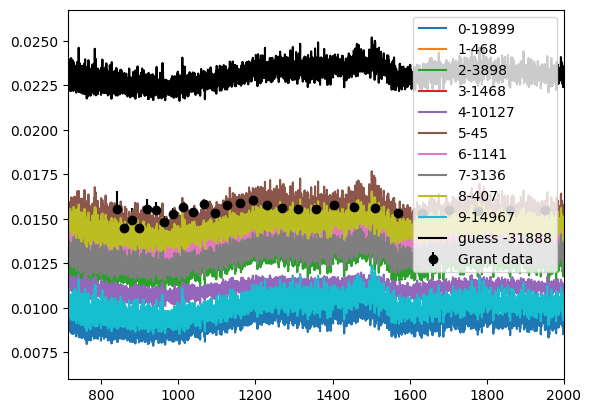

In [10]:
plt.figure()
#lets plot the data 
for ikey in DATA_DICT.keys(): 
    plt.errorbar(x=DATA_DICT[ikey][0], y=DATA_DICT[ikey][1], yerr=DATA_DICT[ikey][2],color='black',
                 marker='o', ls=' ',label='Grant data')

ntests = 10 #lets do 10 random tests 
for i in range(ntests): 
    cube = np.random.uniform(size=len(PARAMS))
    params_evaluations = PRIOR(cube)
    x,y,off,err = MODEL(params_evaluations)
    loglike = loglikelihood(params_evaluations)
    #REMEMBER: we only added the offset parameter in the LIKELIHOOD step, so when plotting 
    #you have to make sure that your offset is ALSO added to the model (next line) and guess (below)
    plt.plot(x,y-params_evaluations[-1],label=str(i)+str(int(loglike)))

guessx,guessy,off,err = MODEL(GUESS)
guess_log = loglikelihood(GUESS)
plt.plot(guessx,guessy-GUESS[-1],color='black',label='guess '+ str(int(guess_log)))
plt.xlim([1e4/14,1e4/5])
plt.legend()

It looks like our priors are giving us offsets that are skewed a little low. We could go back and adjust our offset prior to be more evenly distributed about the data but otherwise, looks good! Let's go ahead and continue with running UltraNest.

## Step 8) Run the statistical sampler!! 

This will take a little longer than the simple line since we have more parameters now. But the basics are still identical. 

Some things to notice while the sampler is running: 

1. The ultranest visualization (purple) will show you where the solution is headed towards. It looks like (for example) M/H is immediately drawn toward higher values.
2. For parameters like the offset, where we have manually set the prior, make sure that you are seeing a solution which is not going off the bounds of the prior. In this case, it looks like it is converging right at the median of those two values.

In [11]:
import ultranest

In [12]:
sampler = ultranest.ReactiveNestedSampler(PARAMS, loglikelihood, PRIOR, resume=True, log_dir='../picaso_data/test/ultranest/grid')
#note if you wanted to run this in the notebook and save the output, you would add resume and log_dir above to save
result = sampler.run()

[ultranest] Resuming from 6206 stored points


[ultranest] Explored until L=-1e+01   [-11.7029..-11.7028]*| it/evals=5800/40927 eff=inf% N=400    0 0  
[ultranest] Likelihood function evaluations: 40927
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -21.52 +- 0.0799
[ultranest] Effective samples strategy satisfied (ESS = 2204.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.08 tail:0.01 total:0.08 required:<0.50
[ultranest] done iterating.


## Analyze Results

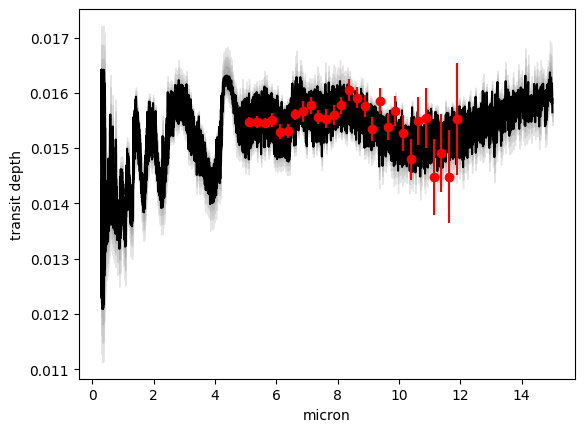

In [13]:
from ultranest.plot import PredictionBand

plt.figure()
first = True
for params in result['samples']:
    x,y,off,err = MODEL(params)
    if first:
        band = PredictionBand(1e4/x);first=False   #transforming xaxis to microns 
    
    #this is a little tricky as we have added an offset to the data 
    #so what i'll do in this case is add the inverse to the model so we can visualise it with the data in the banded solution
    band.add(y-params[-1])

band.line(color='black')#median model

#lets plot the 1, 2, and 3 sigma confidence interval from these samples 
for q, key in zip([k/100/2 for k in [68.27, 95.45, 99.73]], ['1sig','2sig','3sig']): 
        band.shade(q=q,color='grey', alpha=0.2)

#lets plot the data
for ikey in DATA_DICT.keys(): 
    plt.errorbar(x=1e4/DATA_DICT[ikey][0], y=DATA_DICT[ikey][1], yerr=DATA_DICT[ikey][2], color='red', marker='o', ls=' ',label='Grant data')
    
plt.xlabel('micron')
plt.ylabel('transit depth');

When you run the ultranest sampler, the output is named `result`. `result` includes a bunch of things, including points tested, posteriors (best values of each param), and samples. 

`result[‘samples’]` is a matrix of the values of each param at a subset of the live points sampled. This subset is meant to be representative, and it mostly consists of points deemed "important", with a few points from the initial burn-in and a few from the end (the important points are in the yellow region of these [heat maps](https://johannesbuchner.github.io/UltraNest/example-sine-line.html#Trace-plot). If you look at result[‘samples’].shape, you’ll get something like (6206, 5), meaning there were 5 params, and their values are given at 6206 sample points.

`PredictionBand` will go through all 6206 sample points and plot the corresponding 6206 models alongside your data points. It then draws quartiles. All 6206 modeled spectra are saved in the variable `band`.

`band` must first be initialized with by passing an x-array to `PredictionBand`, then you can add the y-values of your various models to `band` one at a time using `band.add`. Note, the offset in this case will not be added to the data, since there is a different offset required for each model. So instead, you will subtract the relevant offset from the associated model spectrum at the time that you add the model y-values to band: `band.add(y-params[-1]`

as a class, `band` also allows you to add things to the plot (such as adding the offset to each line), changing the line color, and shading the plot according to the quartile. So the region that 68.27% of the models fall within will be shaded the darkest gray (1 sigma), 95.45% will be mid-gray (2 sigma), and 99.73% will by light gray (3 sigma). 

You can pass `band` the value of any quartile you want. This code will divide the number by 100 to get a decimal percentage, then divide it by 2, since half the band will be plotted above the median, and half will be plotted below.

`band.line` will draw the median model spectrum. The media model does not always correspond to the max loglikelihood model, although the max loglikelihood model should be close to the median (if all went well). Usually, people report both the median and the max loglikelihood lines.

# Short cut to get grid fitting retrieval template in script form

Same as before but now we will add `grid_kwargs` to set some additional features in the `GridFitter`. Note this is optional and you are always free to change the template manually. 

In [15]:
import picaso.retrieval as pr

In [34]:
rtype='grid' #first let's specify the retrieval type 'grid' 
script_name='run_test.py' #specify a script name 
#sampler_output='/data/test/ultranest/grid'
sampler_output='../picaso_data/test/ultranest/grid' ##### REWA #####

#grid_location = '/data2/models/WASP-17b/spec/zenodo/v1'# should ultimately point to location of all .nc files
grid_location = '../picaso_data/models/WASP-17b/spec/zenodo/v1'##### REWA #####
grid_name = 'cldfree' #for your own book-keeping
to_fit = 'transit_depth' #this is based on what you want to fit in the xarray files s

#new!
grid_kwargs={'grid_location':grid_location,'grid_name':grid_name,'to_fit':to_fit}

pr.create_template(rtype,script_name,sampler_output,grid_kwargs=grid_kwargs)

Open up `run_test.py` and modify what you need. We have marked key areas you might want to modify with "CHANGEME"

Running with mpiexec with 5 cpu: 

    >> mpiexec -n 5 python -m mpi4py run_test.py

## Some tricks and tips for once you have a built a script

Now that you have a built a script, we can import it to grab our built models, priors, parameters set, etc. 

In [35]:
import run_test as rt #YOUR OWN unique script 

Note, if you change the run_test.py file, you'll need to run extra code to re-import it. (Normally your notebook keeps track of all the modules you've imported, and if it sees you've already imported it, it won't import it again.)
    
If working in a Jupyter Notebook, run the following code once, and it will ensure modules are automatically reloaded any time the source code changes:

    %load_ext autoreload
    %autoreload 2


Now you can easily grab what you need directly and no need to have this in a notebook. 

In [36]:
DATA_DICT = rt.get_data()
PARAMS = getattr(rt.param_set,'grid')
MODEL = getattr(rt.model_set,'grid')
PRIOR = getattr(rt.prior_set,'grid')
GUESS = getattr(rt.guesses_set,'grid')

We can also see use the fitter class to continue our analysis (which we will do in the following section)

# PICASO Analysis Tools from Saved Samples 

This part relies on having ran the above script for the run_test.py and having output in a directory defined by `sampler_output`
## Auto read ultranest results

The function `pr.get_info()` gives you back some of the most highly used output products: 

- `samples_equal`: equally weighted samples from the posterior
- `max_logl` : the maximum loglikelihood (otherwise known as the Bayesian evidence)
- `max_logl_point` : the set of parameters that is associated with the maximum loglikelihood
- `med_intervals` : the 1 sigma median constraint intervals for each of the parameters of interest
- `ultranest_out` : the raw ultranest output 

In [37]:
results = pr.get_info(sampler_output, PARAMS)

In [38]:
results.keys()

dict_keys(['samples_equal', 'max_logl', 'max_logl_point', 'med_point', 'med_intervals', 'param_names', 'ultranest_out'])

## Get spectra interval bands and evaluate max loglikelihood spectra  

The function `pr.get_evaluations()` allows you to evaluate the max loglikelihood spectrum by returning:

- `bands_spectra`: 1,2,3 sigma bands for spectra (contains keys such as `1sig_lo` and `1sig_hi` for the spectra)
- `max_logl_spectra`: the spectra evaluated at the max logl point
- `max_logl_error_inflation` : if exists, the error inflation associated with the max logl point
- `max_logl_offsets` : If exists, the offsets associated with the max logl point
- `wavelength`: the wavelength grid in um 

In [21]:
n_draws=200 #number of evaluations for which to compute your banded spectra and get median model
evaluations = pr.get_evaluations(results['samples_equal'], results['max_logl_point'], MODEL, n_draws,
                                 regrid=100.0,#spectral resolution to regrid to
                                 pressure_bands=[])#'temperature','H2O','CO2','CO','CH4']) 

Creating spectra for all 6206 points from the sample is time-consuming, but we can instead make spectra for a randomly-grabbed subset of those points. Determine the size of the subset you want (here `n_draws = 200` means you’re pulling 200 random points from the sample). Then use `pr.get_evaluations` and it will pull `n_draws` points from `results[‘samples_equal’]` and `results[‘max_logl_point’]`, run them through `MODEL` to get their spectra, and `regrid` them down to a lower resolution (here 100).

In [39]:
evaluations.keys()

dict_keys(['bands_spectra', 'max_logl_spectra', 'max_logl_error_inflation', 'max_logl_offsets', 'wavelength'])

(5.0, 14.0)

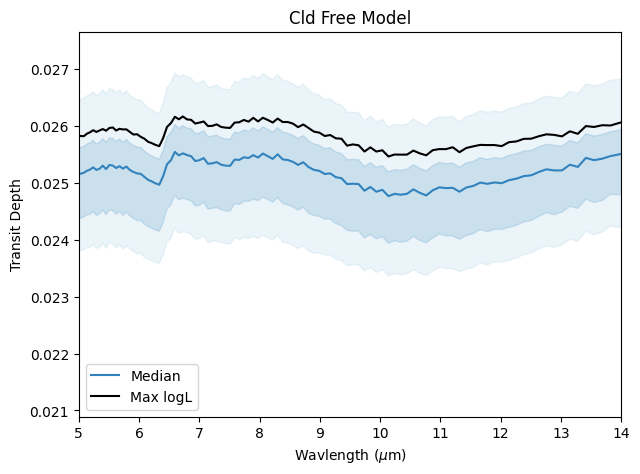

In [42]:
fig,axs = plt.subplots(1,1,figsize=(7,5))
color_scale =  pr.pals.Blues[3]
resolution=100
f=pr.plot_spectra_bands(evaluations, color_scale, ax=axs, R=resolution)
axs.set_title('Cld Free Model')#add other styles here 
axs.set_xlabel(r'Wavlength ($\mu$m)')
axs.set_ylabel('Transit Depth')
axs.set_xlim([5,14])

## Get Reduced Chi Squared Statistic of Max Logl spectrum Incl Offsets

The function `pr.get_chisq_max()` returns:

- `wavenumber`: new regridded wavenumber grid on data axis
- `model` : model regridded on data axis
- `datay` : data with offset included
- `datae` : data error (no error inflation included )
- `chisq_per_datapt` : chi squared per data point (DOF=len of data array)

In [24]:
chi_info = pr.get_chisq_max(evaluations, DATA_DICT)

In [25]:
chi_info['chisq_per_datapt']

0.837198255595884

Text(0, 0.5, 'Transit Depth')

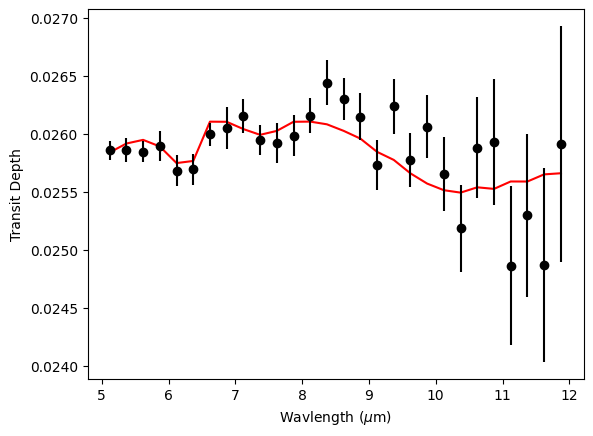

In [43]:
plt.plot(1e4/chi_info['wavenumber'], chi_info['model'],color='red',label='max logl model')
plt.errorbar(x=1e4/chi_info['wavenumber'], y=chi_info['datay'], yerr=chi_info['datae'], 
             color='black',marker='o', ls=' ')
plt.xlabel(r'Wavlength ($\mu$m)')
plt.ylabel('Transit Depth')

The `pr.get_chisq_max` function will take in the data and the evaluations (which is the subset of samples), regrid the sample points on the same axis as the data, do error_inf and offset corrections, then return the regridded model. It will also compute a version of chi-squared called `chisq-per-datapt`. 

Normally a reduced chi-squared calculation includes DOF = number of data points – number of model params. But in the exoplanet field, the number of model params can vary widely and doesn’t have much import, so usually we just say DOF = number of data points, and thus report chi-squared per data point.

## Get all bundled results in xarray format

What does `data_output` do? 

1. bundles all the median and sigma banded output data into an xarray
2. adds all the constraint intervals to your xarray in latex format
3. creates some default plots of banded spectra (banded chem if you have created it) and corner plots
4. creates a pickle of your equally weighted samples if you have requested it

Above, we were mostly focusing on the 5-12 micron range, which is where our data points fell and thus was the region where the fitting was happening. But the model spectra are computed from 1-14 microns, so the output will include that full wavelength range.

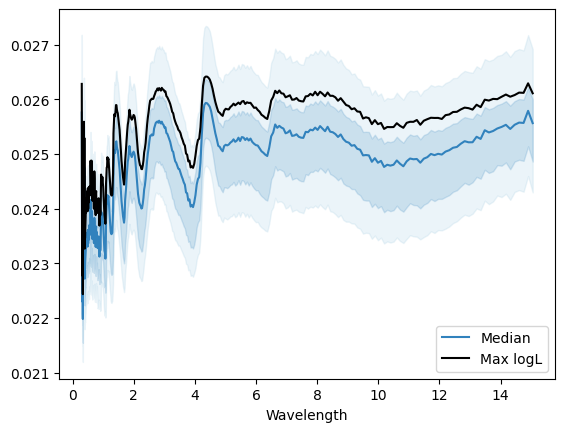

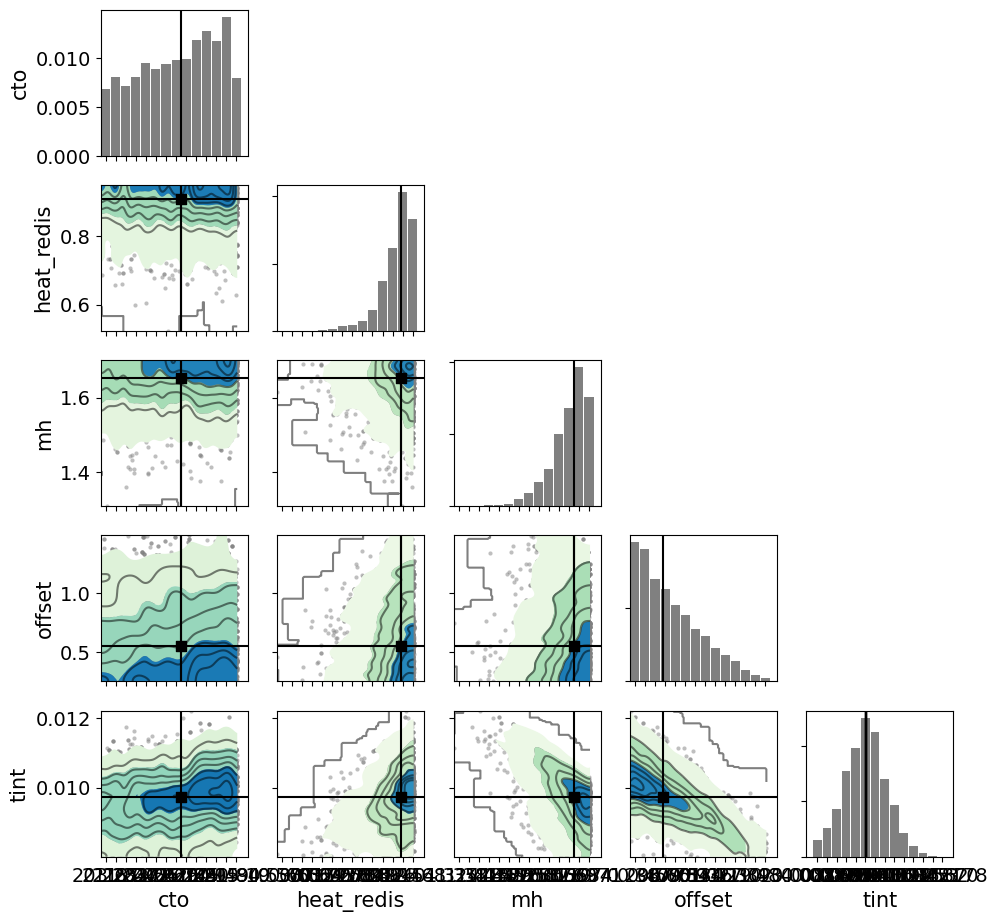

In [27]:
#filename = '/data/test/output/tagname'#name of file (without extension!!) where you want the output returned 
filename = '../picaso_data/test/output/tagname'##### REWA, must create this directory first #####
return_samples = True #do you want a pickle file created of all the equally weighted samples? 
spectrum_tag = 'transit_depth' #in the xarray what do you want the spectrum called? 
spectrum_unit = 'cm**2/cm**2' #what are the units of your spectrum? 
author = "NE Batalha" #who did the analysis? this is for the xarray
contact = "natasha.e.batalha@nasa.gov" #how can you be contacted? this is for the xarray
model_description = "cloud free grid fit" #describe your model so people will know what it is 
code = "PICASO,Ultranest" #what codes did you use for this analysis? 

bxr=pr.data_output(evaluations, results, chi_info, filename, return_samples=True,
                    spectrum_tag=spectrum_tag, spectrum_unit=spectrum_unit,
                    author=author, contact=contact,
                    model_description=model_description,
                    code=code,)#,
                    #round=[2,1,1,5,3,2,2,1,2,2])

In [28]:
bxr.attrs['intervals_params']
#note if you do not like the round errors here you can adjust what these numbers are rounded to with 
#round kwarg to data_output

'{"tint": "$259.351^{+29.059}_{-37.744}$", "heat_redis": "$0.909^{+0.029}_{-0.056}$", "mh": "$1.653^{+0.034}_{-0.062}$", "cto": "$0.546^{+0.386}_{-0.213}$", "offset": "$0.009^{+0.0}_{-0.0}$"}'

## Stylize Plots

Our default plots were not great, let's beautify them a little 

(5.0, 14.0)

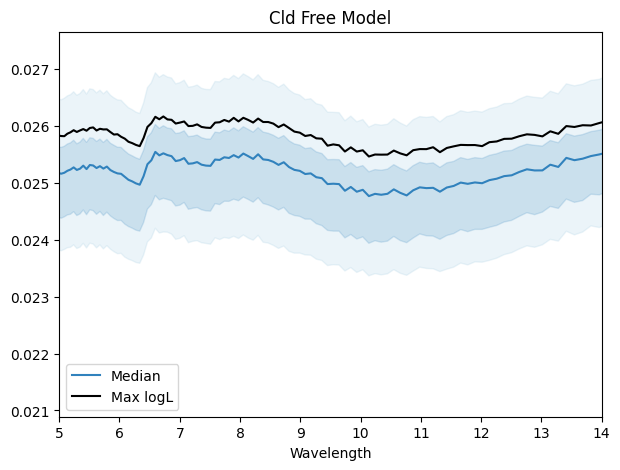

In [29]:
fig,axs = plt.subplots(1,1,figsize=(7,5))
color_scale =  pr.pals.Blues[3]
resolution=100
f=pr.plot_spectra_bands(evaluations, color_scale, ax=axs, R=resolution)
axs.set_title('Cld Free Model')#add other styles here 
axs.set_xlim([5,14])

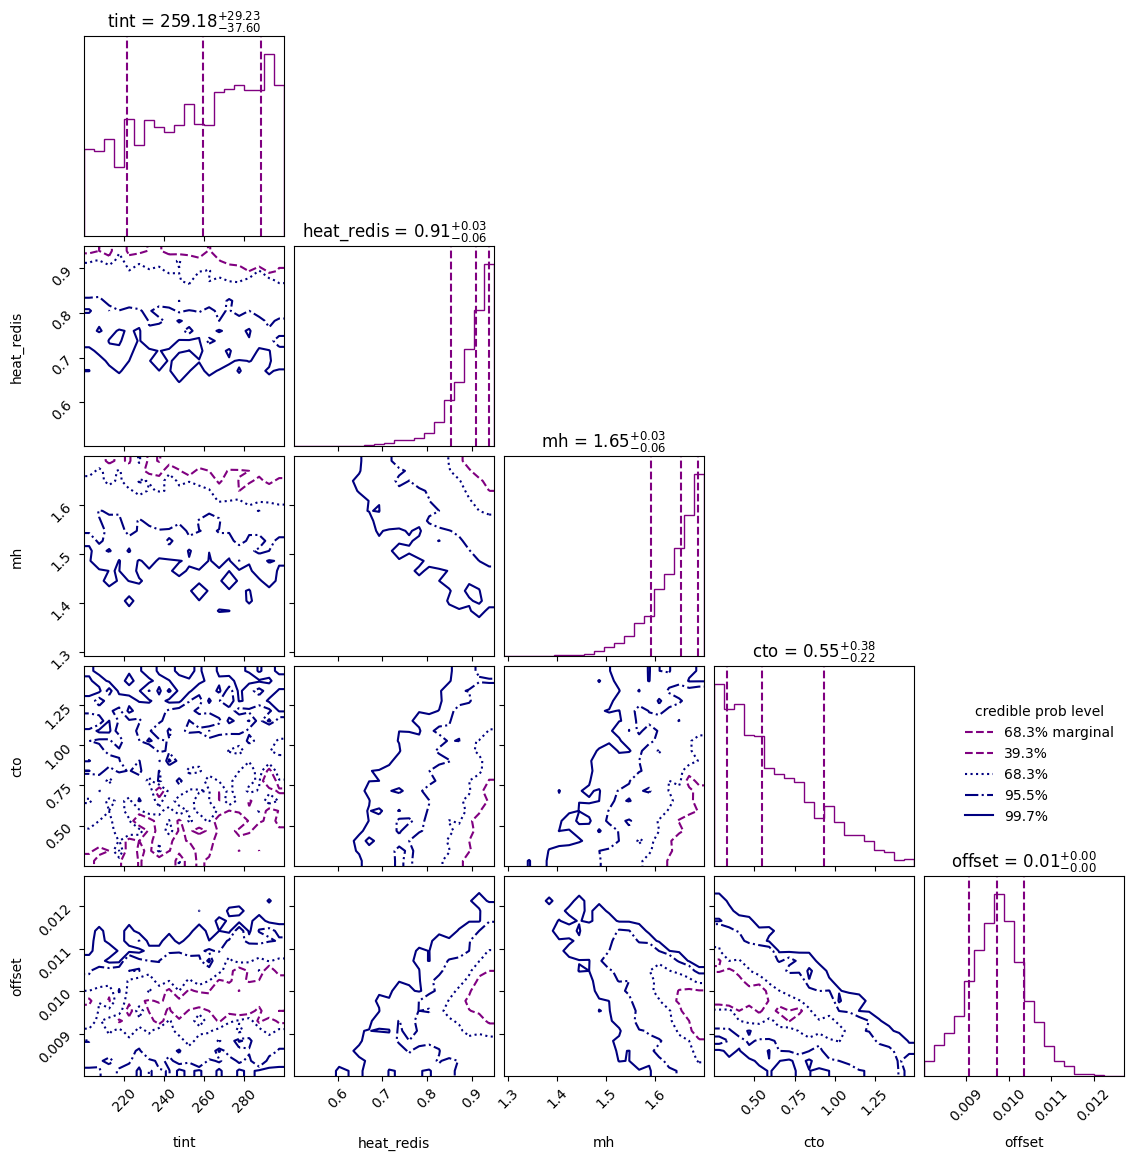

In [56]:
from ultranest.plot import cornerplot
p=cornerplot(result)